### Sentiment Analysis of COVID-19 Vaccine Tweets
Gourav Verma<br>
DSC-680 T302, Spring 21<br>
Prof Fadi Alsaleem

In [1]:
# Import important libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly as pl
import re
import datetime

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
#import spacy
import pickle

import tensorflow as tf
import keras
from keras.utils.vis_utils import plot_model

import seaborn as sns
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\goura\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Read COVID-19 Vaccine Tweets dataset

In [2]:
# Read the data
raw_df = pd.read_csv("vaccination_all_tweets.csv")
raw_df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69718 entries, 0 to 69717
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                69718 non-null  int64 
 1   user_name         69718 non-null  object
 2   user_location     53891 non-null  object
 3   user_description  64846 non-null  object
 4   user_created      69718 non-null  object
 5   user_followers    69718 non-null  int64 
 6   user_friends      69718 non-null  int64 
 7   user_favourites   69718 non-null  int64 
 8   user_verified     69718 non-null  bool  
 9   date              69718 non-null  object
 10  text              69718 non-null  object
 11  hashtags          54904 non-null  object
 12  source            69599 non-null  object
 13  retweets          69718 non-null  int64 
 14  favorites         69718 non-null  int64 
 15  is_retweet        69718 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 7.6+ MB


## Sentiment Analysis

### Read train dataset for tweets
Downloaded from: https://www.kaggle.com/c/tweet-sentiment-extraction <br>
We will use if only to train our model. Not for sentiment analysis

In [4]:
tweet_train = pd.read_csv("train.csv")

In [5]:
tweet_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


<AxesSubplot:>

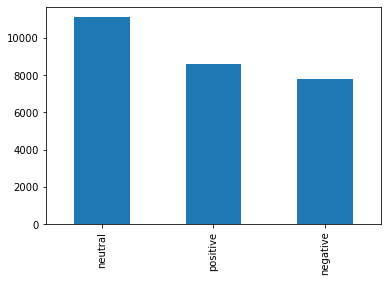

In [6]:
# Bar plot of sentiments
fig, ax = plt.subplots()
tweet_train['sentiment'].value_counts().plot(ax=ax, kind='bar')

In [7]:
# Remove unnecessary columns
tweet_train = tweet_train.drop(['textID', 'text'], axis=1)
tweet_train.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [8]:
tweet_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   selected_text  27480 non-null  object
 1   sentiment      27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


In [9]:
# Drop null rows with null
tweet_train = tweet_train.dropna()
tweet_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   selected_text  27480 non-null  object
 1   sentiment      27480 non-null  object
dtypes: object(2)
memory usage: 644.1+ KB


### Data Cleaning

In [10]:
def data_cleaning(text):
    """
    Function to perform below tasks:
    - Remove URL
    - Remove emails
    - Remove newline characters
    - Remove single quotes
    """
    # Remove URLs
    url = re.compile(r'https?://\S+|www\.\S+')
    textc = url.sub(r'', text)
    
    # Remove Emails
    textc = re.sub('\S*@\S*\s?', '', textc)
    
    # Remove newline
    textc = re.sub('\s+', ' ', textc)
    
    # Remove single quotes
    textc = re.sub("\'", "", textc)
    
    return textc

In [11]:
text_list=[]

# Split selected_text to list
df_list = tweet_train['selected_text'].values.tolist()

# Clean the texts
for t in range(len(df_list)):
    text_list.append(data_cleaning(df_list[t]))

list(text_list[5:15])

[' - some shameless plugging for the best Rangers forum on earth',
 'fun',
 'Soooo high',
 'Both of you',
 'Wow... u just became cooler.',
 'as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff',
 'like',
 'DANGERously',
 'lost',
 'test test from the LG enV2']

In [12]:
def data_word(sent):
    """
    Function to split sentences to words 
    """
    for s in sent:
        yield(gensim.utils.simple_preprocess(str(s), deacc=True))
    
    return

text_word = list(data_word(text_list))

print(text_word[5:15])

[['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'just', 'became', 'cooler'], ['as', 'much', 'as', 'love', 'to', 'be', 'hopeful', 'reckon', 'the', 'chances', 'are', 'minimal', 'never', 'gonna', 'get', 'my', 'cake', 'and', 'stuff'], ['like'], ['dangerously'], ['lost'], ['test', 'test', 'from', 'the', 'lg', 'env']]


### Detokenization

In [13]:
def detok(text_word):
    return 

text_detok = []

for i in range(len(text_word)):
    text_detok.append(TreebankWordDetokenizer().detokenize(text_word[i]))


print(text_detok[5:15])

['some shameless plugging for the best rangers forum on earth', 'fun', 'soooo high', 'both of you', 'wow just became cooler', 'as much as love to be hopeful reckon the chances are minimal never gonna get my cake and stuff', 'like', 'dangerously', 'lost', 'test test from the lg env']


In [14]:
# Convert detokenized text to array
text_ar = np.array(text_detok)

### Label Encoding

In [15]:
# Convert categorical values to float

label = np.array(tweet_train['sentiment'])
num = []
for i in range(len(label)):
    if label[i] == 'neutral':
        num.append(0)
    if label[i] == 'negative':
        num.append(1)
    if label[i] == 'positive':
        num.append(2)

num = np.array(num)

label = tf.keras.utils.to_categorical(num, 3, dtype="float32")
label

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

### Sequencing and Splitting

In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [17]:
max_words = 5000
max_len = 200

tokenize = Tokenizer(num_words=max_words)
tokenize.fit_on_texts(text_ar)
seq = tokenize.texts_to_sequences(text_ar)
tweet = pad_sequences(seq, maxlen=max_len)
print(tweet)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  397   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  372   10    3]
 [   0    0    0 ...   24  542    4]
 [   0    0    0 ... 2424  199  657]]


### Model Building

In [18]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(tweet,label, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20610 6870 20610 6870


#### Single LSTM

In [19]:
mod1 = Sequential()
mod1.add(layers.Embedding(max_words, 20))
mod1.add(layers.LSTM(15, dropout=0.5))
mod1.add(layers.Dense(3, activation='softmax'))

mod1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

ckpt1 = ModelCheckpoint('mod1.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', 
                       period=1, save_weights_only=False)

hist = mod1.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test), callbacks=[ckpt1])

645/645 [==============================] - 35s 53ms/step - loss: 0.9119 - accuracy: 0.5929 - val_loss: 0.6578 - val_accuracy: 0.7182

Epoch 00001: val_accuracy improved from -inf to 0.71820, saving model to mod1.hdf5


In [20]:
mod1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          100000    
_________________________________________________________________
lstm (LSTM)                  (None, 15)                2160      
_________________________________________________________________
dense (Dense)                (None, 3)                 48        
Total params: 102,208
Trainable params: 102,208
Non-trainable params: 0
_________________________________________________________________


#### Bidirectional LSTM

In [21]:
mod2 = Sequential()
mod2.add(layers.Embedding(max_words, 40, input_length=max_len))
mod2.add(layers.Bidirectional(layers.LSTM(20, dropout=0.6)))
mod2.add(layers.Dense(3, activation='softmax'))
mod2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

ckpt2 = ModelCheckpoint('mod2.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', 
                       period=1, save_weights_only=False)

hist = mod2.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test), callbacks=[ckpt2])

645/645 [==============================] - 52s 76ms/step - loss: 0.8849 - accuracy: 0.5927 - val_loss: 0.6527 - val_accuracy: 0.7274

Epoch 00001: val_accuracy improved from -inf to 0.72737, saving model to mod2.hdf5


In [22]:
mod2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 40)           200000    
_________________________________________________________________
bidirectional (Bidirectional (None, 40)                9760      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 123       
Total params: 209,883
Trainable params: 209,883
Non-trainable params: 0
_________________________________________________________________


#### 1D CNN

In [23]:
mod3 = Sequential()
mod3.add(layers.Embedding(max_words, 40, input_length=max_len))
mod3.add(layers.Conv1D(20, 6, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3), 
                       bias_regularizer=regularizers.l2(2e-3)))
mod3.add(layers.MaxPooling1D(5))
mod3.add(layers.Conv1D(20, 6, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3), 
                       bias_regularizer=regularizers.l2(2e-3)))
mod3.add(layers.GlobalMaxPooling1D())
mod3.add(layers.Dense(3, activation='softmax'))
mod3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

ckpt3 = ModelCheckpoint('mod3.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', 
                       period=1, save_weights_only=False)

hist = mod3.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test), callbacks=[ckpt3])

645/645 [==============================] - 6s 8ms/step - loss: 1.2703 - acc: 0.4789 - val_loss: 0.8991 - val_acc: 0.6150


In [24]:
mod3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 40)           200000    
_________________________________________________________________
conv1d (Conv1D)              (None, 195, 20)           4820      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 39, 20)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 34, 20)            2420      
_________________________________________________________________
global_max_pooling1d (Global (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 63        
Total params: 207,303
Trainable params: 207,303
Non-trainable params: 0
________________________________________________

**We can see that Bidirectional RNN model showed highest accuracy. Lets validate the model.**

In [25]:
predict=mod2.predict(X_test)

<AxesSubplot:>

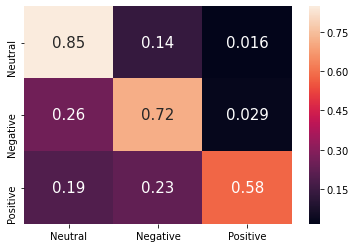

In [26]:
# Plot confusion matrix

c = confusion_matrix(y_test.argmax(axis=1), np.around(predict, decimals=0).argmax(axis=1))
matrix = pd.DataFrame(c, index=['Neutral', 'Negative', 'Positive'], columns=['Neutral', 'Negative', 'Positive'])

matrix = matrix.astype('float')/matrix.sum(axis=1)[:, np.newaxis]

sns.heatmap(matrix, annot=True, annot_kws={"size": 15})


### Sentiment analysis on COVID-19 Tweet Dataset

In [27]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69718 entries, 0 to 69717
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                69718 non-null  int64 
 1   user_name         69718 non-null  object
 2   user_location     53891 non-null  object
 3   user_description  64846 non-null  object
 4   user_created      69718 non-null  object
 5   user_followers    69718 non-null  int64 
 6   user_friends      69718 non-null  int64 
 7   user_favourites   69718 non-null  int64 
 8   user_verified     69718 non-null  bool  
 9   date              69718 non-null  object
 10  text              69718 non-null  object
 11  hashtags          54904 non-null  object
 12  source            69599 non-null  object
 13  retweets          69718 non-null  int64 
 14  favorites         69718 non-null  int64 
 15  is_retweet        69718 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 7.6+ MB


In [28]:
text_list=[]

# Split selected_text to list
df_list = raw_df['text'].values.tolist()

# Clean the texts
for t in range(len(df_list)):
    text_list.append(data_cleaning(df_list[t]))

list(text_list[5:15])

['Does anyone have any useful advice/guidance for whether the COVID vaccine is safe whilst breastfeeding?… ',
 'it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… ',
 'There have not been many bright days in 2020 but here are some of the best 1. #BidenHarris winning #Election2020… ',
 'Covid vaccine; You getting it? #CovidVaccine #covid19 #PfizerBioNTech #Moderna',
 '#CovidVaccine States will start getting #COVID19Vaccine Monday, #US says #pakustv #NYC #Healthcare #GlobalGoals… ',
 'while deaths are closing in on the 300,000 mark... millions of people wait #PfizerBioNTech #Vaccine ! - The first U… ',
 '#COVID19 #CovidVaccine #vaccine #Corona #PfizerBioNTech #bbcnews #NYTimes #BBCNews Best wishes to the US… ',
 'The agency also released new information for health care providers and for patients as the US shipped millions of d… ',
 'For all the women and healthcare providers who have been asking about the safety of the #Pfi

In [29]:
text_word = list(data_word(text_list))

print(text_word[5:15])

[['does', 'anyone', 'have', 'any', 'useful', 'advice', 'guidance', 'for', 'whether', 'the', 'covid', 'vaccine', 'is', 'safe', 'whilst', 'breastfeeding'], ['it', 'is', 'bit', 'sad', 'to', 'claim', 'the', 'fame', 'for', 'success', 'of', 'vaccination', 'on', 'patriotic', 'competition', 'between', 'usa', 'canada', 'uk', 'and'], ['there', 'have', 'not', 'been', 'many', 'bright', 'days', 'in', 'but', 'here', 'are', 'some', 'of', 'the', 'best', 'bidenharris', 'winning', 'election'], ['covid', 'vaccine', 'you', 'getting', 'it', 'covidvaccine', 'covid', 'pfizerbiontech', 'moderna'], ['covidvaccine', 'states', 'will', 'start', 'getting', 'covid', 'vaccine', 'monday', 'us', 'says', 'pakustv', 'nyc', 'healthcare', 'globalgoals'], ['while', 'deaths', 'are', 'closing', 'in', 'on', 'the', 'mark', 'millions', 'of', 'people', 'wait', 'pfizerbiontech', 'vaccine', 'the', 'first'], ['covid', 'covidvaccine', 'vaccine', 'corona', 'pfizerbiontech', 'bbcnews', 'nytimes', 'bbcnews', 'best', 'wishes', 'to', 'th

### Detokenization

In [30]:
text_detok = []

for i in range(len(text_word)):
    text_detok.append(TreebankWordDetokenizer().detokenize(text_word[i]))


print(text_detok[5:15])

['does anyone have any useful advice guidance for whether the covid vaccine is safe whilst breastfeeding', 'it is bit sad to claim the fame for success of vaccination on patriotic competition between usa canada uk and', 'there have not been many bright days in but here are some of the best bidenharris winning election', 'covid vaccine you getting it covidvaccine covid pfizerbiontech moderna', 'covidvaccine states will start getting covid vaccine monday us says pakustv nyc healthcare globalgoals', 'while deaths are closing in on the mark millions of people wait pfizerbiontech vaccine the first', 'covid covidvaccine vaccine corona pfizerbiontech bbcnews nytimes bbcnews best wishes to the us', 'the agency also released new information for health care providers and for patients as the us shipped millions of', 'for all the women and healthcare providers who have been asking about the safety of the pfizerbiontech', 'expect sites across all the states to receive vaccine on monday another site

In [31]:
# Convert detokenized text to array
text_ar = np.array(text_detok)

### Add an empty sentiment column to the dataset

In [32]:
raw_df["Sentiments"] = np.nan

In [33]:
len(text_list)

69718

### Apply best model (Bidirection RNN) to the dataset

In [34]:
sentiment = ['Neutral','Negative','Positive']
for l in range(len(text_list)):
    seq = tokenize.texts_to_sequences([text_list[l]])
    tweet = pad_sequences(seq, maxlen=max_len)
    raw_df["Sentiments"][l] = sentiment[np.around(mod2.predict(tweet), decimals=0).argmax(axis=1)[0]]
    if (l % 6970 == 0):
        perc = l/len(text_list) * 100
        f_perc = "{:.0f}".format(perc)
        print(f_perc,"%")


0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %


**Applying model to dataset takes long time, So saved final dataset to a .CSV file. I will be using this CSV file for further analysis..**

In [35]:
final_df = raw_df
raw_df.to_csv('raw_df.csv', index=False)

In [36]:
tweet_sent = pd.read_csv('raw_df.csv')

pd.set_option('display.max_colwidth', None)
tweet_sent[["text", "Sentiments"]].head(15)

,text,Sentiments
0,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,Neutral
1,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",Neutral
2,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,Neutral
3,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",Neutral
4,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,Neutral
5,Does anyone have any useful advice/guidance for whether the COVID vaccine is safe whilst breastfeeding?… https://t.co/EifsyQoeKN,Neutral
6,"it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP",Neutral
7,There have not been many bright days in 2020 but here are some of the best \n1. #BidenHarris winning #Election2020… https://t.co/77u4f8XXfx,Neutral
8,Covid vaccine; You getting it?\n\n #CovidVaccine #covid19 #PfizerBioNTech #Moderna,Negative
9,"#CovidVaccine \n\nStates will start getting #COVID19Vaccine Monday, #US says \n#pakustv #NYC #Healthcare #GlobalGoals… https://t.co/MksOvBvs5w",Neutral


In [37]:
# Sentiment Counts
tweet_sent.groupby('Sentiments')['id'].nunique()

Sentiments
Negative     7456
Neutral     60925
Positive     1337
Name: id, dtype: int64